In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/793 [..............................] - ETA: 13:41 - loss: 0.3531 - STD: 1.4023e-04 - MAE: 0.5858

 11/793 [..............................] - ETA: 4s - loss: 0.0659 - STD: 2.4062e-04 - MAE: 0.1899   

 20/793 [..............................] - ETA: 4s - loss: 0.0503 - STD: 1.3603e-04 - MAE: 0.1717

 29/793 [>.............................] - ETA: 4s - loss: 0.0421 - STD: 9.8731e-05 - MAE: 0.1564

 38/793 [>.............................] - ETA: 4s - loss: 0.0347 - STD: 7.9406e-05 - MAE: 0.1383

 47/793 [>.............................] - ETA: 4s - loss: 0.0301 - STD: 6.6476e-05 - MAE: 0.1285

 56/793 [=>............................] - ETA: 4s - loss: 0.0268 - STD: 5.6885e-05 - MAE: 0.1198

 65/793 [=>............................] - ETA: 4s - loss: 0.0244 - STD: 4.9837e-05 - MAE: 0.1136

 74/793 [=>............................] - ETA: 4s - loss: 0.0226 - STD: 4.4815e-05 - MAE: 0.1094

 83/793 [==>...........................] - ETA: 4s - loss: 0.0211 - STD: 4.0688e-05 - MAE: 0.1056

 92/793 [==>...........................] - ETA: 4s - loss: 0.0200 - STD: 3.7336e-05 - MAE: 0.1025

101/793 [==>...........................] - ETA: 4s - loss: 0.0190 - STD: 3.4724e-05 - MAE: 0.1001

109/793 [===>..........................] - ETA: 4s - loss: 0.0183 - STD: 3.2802e-05 - MAE: 0.0984

117/793 [===>..........................] - ETA: 4s - loss: 0.0177 - STD: 3.1071e-05 - MAE: 0.0968

126/793 [===>..........................] - ETA: 3s - loss: 0.0171 - STD: 2.9489e-05 - MAE: 0.0953

135/793 [====>.........................] - ETA: 3s - loss: 0.0166 - STD: 2.8187e-05 - MAE: 0.0940

144/793 [====>.........................] - ETA: 3s - loss: 0.0161 - STD: 2.7029e-05 - MAE: 0.0928

152/793 [====>.........................] - ETA: 5s - loss: 0.0157 - STD: 2.6192e-05 - MAE: 0.0917

162/793 [=====>........................] - ETA: 5s - loss: 0.0153 - STD: 2.5323e-05 - MAE: 0.0908

171/793 [=====>........................] - ETA: 5s - loss: 0.0150 - STD: 2.4678e-05 - MAE: 0.0900

180/793 [=====>........................] - ETA: 5s - loss: 0.0147 - STD: 2.4211e-05 - MAE: 0.0892

189/793 [======>.......................] - ETA: 5s - loss: 0.0144 - STD: 2.3828e-05 - MAE: 0.0885

198/793 [======>.......................] - ETA: 4s - loss: 0.0142 - STD: 2.3492e-05 - MAE: 0.0879

207/793 [======>.......................] - ETA: 4s - loss: 0.0140 - STD: 2.3338e-05 - MAE: 0.0874

216/793 [=======>......................] - ETA: 4s - loss: 0.0138 - STD: 2.3289e-05 - MAE: 0.0868

225/793 [=======>......................] - ETA: 4s - loss: 0.0136 - STD: 2.3378e-05 - MAE: 0.0864

234/793 [=======>......................] - ETA: 4s - loss: 0.0134 - STD: 2.3608e-05 - MAE: 0.0860

243/793 [========>.....................] - ETA: 4s - loss: 0.0133 - STD: 2.4053e-05 - MAE: 0.0856

252/793 [========>.....................] - ETA: 4s - loss: 0.0131 - STD: 2.4708e-05 - MAE: 0.0853

261/793 [========>.....................] - ETA: 4s - loss: 0.0130 - STD: 2.5553e-05 - MAE: 0.0849

269/793 [=========>....................] - ETA: 4s - loss: 0.0129 - STD: 2.6597e-05 - MAE: 0.0846

278/793 [=========>....................] - ETA: 3s - loss: 0.0127 - STD: 2.8095e-05 - MAE: 0.0843

287/793 [=========>....................] - ETA: 3s - loss: 0.0126 - STD: 3.0012e-05 - MAE: 0.0839

296/793 [==========>...................] - ETA: 3s - loss: 0.0125 - STD: 3.2452e-05 - MAE: 0.0837

305/793 [==========>...................] - ETA: 3s - loss: 0.0124 - STD: 3.5637e-05 - MAE: 0.0834

314/793 [==========>...................] - ETA: 3s - loss: 0.0123 - STD: 3.9735e-05 - MAE: 0.0832

323/793 [===========>..................] - ETA: 3s - loss: 0.0123 - STD: 4.5135e-05 - MAE: 0.0830

332/793 [===========>..................] - ETA: 3s - loss: 0.0122 - STD: 5.1987e-05 - MAE: 0.0828

341/793 [===========>..................] - ETA: 3s - loss: 0.0121 - STD: 6.1161e-05 - MAE: 0.0826

350/793 [============>.................] - ETA: 3s - loss: 0.0120 - STD: 7.3424e-05 - MAE: 0.0824

359/793 [============>.................] - ETA: 3s - loss: 0.0119 - STD: 9.0165e-05 - MAE: 0.0822

368/793 [============>.................] - ETA: 3s - loss: 0.0119 - STD: 1.1255e-04 - MAE: 0.0820

377/793 [=============>................] - ETA: 3s - loss: 0.0118 - STD: 1.4306e-04 - MAE: 0.0819

386/793 [=============>................] - ETA: 2s - loss: 0.0117 - STD: 1.8543e-04 - MAE: 0.0817

395/793 [=============>................] - ETA: 2s - loss: 0.0117 - STD: 2.4656e-04 - MAE: 0.0816

404/793 [==============>...............] - ETA: 2s - loss: 0.0116 - STD: 3.3386e-04 - MAE: 0.0814

413/793 [==============>...............] - ETA: 2s - loss: 0.0116 - STD: 4.5753e-04 - MAE: 0.0813

422/793 [==============>...............] - ETA: 2s - loss: 0.0115 - STD: 6.3164e-04 - MAE: 0.0811

431/793 [===============>..............] - ETA: 2s - loss: 0.0114 - STD: 8.6540e-04 - MAE: 0.0809

440/793 [===============>..............] - ETA: 2s - loss: 0.0114 - STD: 0.0012 - MAE: 0.0807    

449/793 [===============>..............] - ETA: 2s - loss: 0.0113 - STD: 0.0016 - MAE: 0.0805

458/793 [================>.............] - ETA: 2s - loss: 0.0112 - STD: 0.0021 - MAE: 0.0803

467/793 [================>.............] - ETA: 2s - loss: 0.0112 - STD: 0.0026 - MAE: 0.0800

476/793 [=================>............] - ETA: 2s - loss: 0.0111 - STD: 0.0032 - MAE: 0.0798

485/793 [=================>............] - ETA: 2s - loss: 0.0110 - STD: 0.0038 - MAE: 0.0796

494/793 [=================>............] - ETA: 2s - loss: 0.0110 - STD: 0.0044 - MAE: 0.0794

503/793 [==================>...........] - ETA: 2s - loss: 0.0109 - STD: 0.0050 - MAE: 0.0791

512/793 [==================>...........] - ETA: 1s - loss: 0.0108 - STD: 0.0056 - MAE: 0.0789

521/793 [==================>...........] - ETA: 1s - loss: 0.0107 - STD: 0.0062 - MAE: 0.0786

530/793 [===================>..........] - ETA: 1s - loss: 0.0107 - STD: 0.0069 - MAE: 0.0783

539/793 [===================>..........] - ETA: 1s - loss: 0.0106 - STD: 0.0075 - MAE: 0.0780

548/793 [===================>..........] - ETA: 1s - loss: 0.0105 - STD: 0.0082 - MAE: 0.0777

557/793 [====================>.........] - ETA: 1s - loss: 0.0104 - STD: 0.0088 - MAE: 0.0774

566/793 [====================>.........] - ETA: 1s - loss: 0.0104 - STD: 0.0095 - MAE: 0.0771

575/793 [====================>.........] - ETA: 1s - loss: 0.0103 - STD: 0.0102 - MAE: 0.0769

583/793 [=====================>........] - ETA: 1s - loss: 0.0102 - STD: 0.0108 - MAE: 0.0766

592/793 [=====================>........] - ETA: 1s - loss: 0.0102 - STD: 0.0115 - MAE: 0.0763

601/793 [=====================>........] - ETA: 1s - loss: 0.0101 - STD: 0.0121 - MAE: 0.0760

610/793 [======================>.......] - ETA: 1s - loss: 0.0100 - STD: 0.0128 - MAE: 0.0757

619/793 [======================>.......] - ETA: 1s - loss: 0.0099 - STD: 0.0135 - MAE: 0.0754

628/793 [======================>.......] - ETA: 1s - loss: 0.0099 - STD: 0.0142 - MAE: 0.0751

637/793 [=======================>......] - ETA: 1s - loss: 0.0098 - STD: 0.0148 - MAE: 0.0748

646/793 [=======================>......] - ETA: 0s - loss: 0.0097 - STD: 0.0155 - MAE: 0.0745

655/793 [=======================>......] - ETA: 0s - loss: 0.0097 - STD: 0.0161 - MAE: 0.0742

664/793 [========================>.....] - ETA: 0s - loss: 0.0096 - STD: 0.0167 - MAE: 0.0739

673/793 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 0.0173 - MAE: 0.0736

682/793 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 0.0180 - MAE: 0.0733

691/793 [=========================>....] - ETA: 0s - loss: 0.0094 - STD: 0.0185 - MAE: 0.0730

700/793 [=========================>....] - ETA: 0s - loss: 0.0093 - STD: 0.0191 - MAE: 0.0727

709/793 [=========================>....] - ETA: 0s - loss: 0.0093 - STD: 0.0197 - MAE: 0.0724

718/793 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 0.0203 - MAE: 0.0722

727/793 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 0.0208 - MAE: 0.0719

736/793 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0213 - MAE: 0.0717

745/793 [===========================>..] - ETA: 0s - loss: 0.0091 - STD: 0.0219 - MAE: 0.0714

754/793 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.0224 - MAE: 0.0711

763/793 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.0229 - MAE: 0.0709

772/793 [============================>.] - ETA: 0s - loss: 0.0089 - STD: 0.0234 - MAE: 0.0706

781/793 [============================>.] - ETA: 0s - loss: 0.0088 - STD: 0.0239 - MAE: 0.0704

790/793 [============================>.] - ETA: 0s - loss: 0.0088 - STD: 0.0244 - MAE: 0.0702

793/793 [==============================] - 7s 7ms/step - loss: 0.0088 - STD: 0.0245 - MAE: 0.0701 - val_loss: 0.0038 - val_STD: 0.0517 - val_MAE: 0.0474


Epoch 2/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0538

  9/793 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0674 - MAE: 0.0502 

 18/793 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0665 - MAE: 0.0503

 27/793 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0660 - MAE: 0.0499

 36/793 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0654 - MAE: 0.0498

 44/793 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0657 - MAE: 0.0496

 53/793 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0661 - MAE: 0.0494

 62/793 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0667 - MAE: 0.0492

 71/793 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0669 - MAE: 0.0489

 80/793 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0675 - MAE: 0.0488

 89/793 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0487

 98/793 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0680 - MAE: 0.0486

107/793 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0486

116/793 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0679 - MAE: 0.0485

125/793 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0682 - MAE: 0.0484

134/793 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0684 - MAE: 0.0482

143/793 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0684 - MAE: 0.0483

152/793 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0684 - MAE: 0.0483

161/793 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0684 - MAE: 0.0483

170/793 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0482

179/793 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0482

188/793 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0481

197/793 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0480

206/793 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0479

215/793 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0478

224/793 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0478

233/793 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0477

242/793 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0477

251/793 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0476

260/793 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0476

269/793 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0475

278/793 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0475

287/793 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0474

296/793 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0473

305/793 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0473

314/793 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0473

323/793 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0473

332/793 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0473

341/793 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0472

350/793 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0472

359/793 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0472

368/793 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0471

377/793 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0471

386/793 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0471

395/793 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0470

404/793 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0470

413/793 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0705 - MAE: 0.0469

422/793 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0469

431/793 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0469

440/793 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0468

449/793 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0468

458/793 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0467

467/793 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0467

476/793 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0467

485/793 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0467

494/793 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0466

503/793 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0466

512/793 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0466

521/793 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0465

530/793 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0465

539/793 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0465

548/793 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0464

557/793 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0464

566/793 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0464

575/793 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0464

584/793 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0463

593/793 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0463

602/793 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0463

611/793 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0462

620/793 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0462

629/793 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0462

638/793 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0462

647/793 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0462

656/793 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0461

665/793 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0461

674/793 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0461

683/793 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0461

692/793 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0460

701/793 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0460

710/793 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0460

719/793 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0461

728/793 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0461

737/793 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0461

746/793 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0461

755/793 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0460

764/793 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0460

773/793 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0460

782/793 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0460

791/793 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0459

793/793 [==============================] - 5s 6ms/step - loss: 0.0038 - STD: 0.0720 - MAE: 0.0459 - val_loss: 0.0032 - val_STD: 0.0559 - val_MAE: 0.0406


Epoch 3/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0443

  8/793 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0729 - MAE: 0.0432 

 16/793 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0436

 25/793 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

 34/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0434

 43/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0434

 52/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0434

 61/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0434

 70/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

 79/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

 88/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0435

 97/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

106/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

115/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

124/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

133/793 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

142/793 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

151/793 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

160/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

169/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

177/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

186/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

195/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

204/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

213/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

222/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

231/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

240/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

249/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

258/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

267/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

276/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

285/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

294/793 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

303/793 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

312/793 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

321/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

330/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

339/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

347/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

356/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

365/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

374/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

383/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

392/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

401/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

408/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

415/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

424/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

433/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

441/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

445/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

452/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

461/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

469/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

476/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

484/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

492/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

501/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

508/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

516/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

524/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

532/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

539/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

546/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

553/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

560/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

567/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

574/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

582/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

589/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

596/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

603/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

610/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

617/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

624/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

631/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

639/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

646/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

653/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

660/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

667/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

674/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

681/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

689/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

696/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

704/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

711/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

718/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

726/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

733/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

740/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

747/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

754/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

762/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

769/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

777/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

785/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

792/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

793/793 [==============================] - 6s 7ms/step - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432 - val_loss: 0.0032 - val_STD: 0.0537 - val_MAE: 0.0403


Epoch 4/10000


  1/793 [..............................] - ETA: 21s - loss: 0.0034 - STD: 0.0690 - MAE: 0.0418

  8/793 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0725 - MAE: 0.0434 

 14/793 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0735 - MAE: 0.0437

 20/793 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0434

 28/793 [>.............................] - ETA: 6s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0430

 35/793 [>.............................] - ETA: 5s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0430

 41/793 [>.............................] - ETA: 6s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0429

 48/793 [>.............................] - ETA: 5s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0429

 54/793 [=>............................] - ETA: 5s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0427

 60/793 [=>............................] - ETA: 5s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0427

 67/793 [=>............................] - ETA: 5s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0427

 73/793 [=>............................] - ETA: 5s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0426

 80/793 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

 87/793 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0425

 93/793 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

100/793 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

106/793 [===>..........................] - ETA: 5s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0427

112/793 [===>..........................] - ETA: 5s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0427

119/793 [===>..........................] - ETA: 5s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0427

125/793 [===>..........................] - ETA: 5s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0427

132/793 [===>..........................] - ETA: 5s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0427

139/793 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0427

147/793 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0427

154/793 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

161/793 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

168/793 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

175/793 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

182/793 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

188/793 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

195/793 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

202/793 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

209/793 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

216/793 [=======>......................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

223/793 [=======>......................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

231/793 [=======>......................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

238/793 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

245/793 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

252/793 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

258/793 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

264/793 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

270/793 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

276/793 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

282/793 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

288/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

294/793 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

300/793 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

306/793 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

312/793 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

318/793 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

324/793 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

330/793 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

336/793 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

343/793 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

351/793 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

358/793 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

365/793 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

372/793 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

379/793 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

386/793 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

393/793 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

400/793 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

408/793 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

416/793 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

423/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

429/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

436/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

443/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

450/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

458/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

465/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

472/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

479/793 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

486/793 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

493/793 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

500/793 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

506/793 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

512/793 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

520/793 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

529/793 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

538/793 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

546/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

555/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

564/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

572/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

580/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

588/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

597/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

605/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

612/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

620/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

629/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

638/793 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

647/793 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

656/793 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

664/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

671/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

679/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

687/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

695/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

703/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

711/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

718/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

726/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

734/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

743/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

752/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

760/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

769/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

776/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

784/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

793/793 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

793/793 [==============================] - 6s 8ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422 - val_loss: 0.0032 - val_STD: 0.0563 - val_MAE: 0.0397


Epoch 5/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0033 - STD: 0.0725 - MAE: 0.0417

  9/793 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0742 - MAE: 0.0412 

 18/793 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0754 - MAE: 0.0414

 27/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0761 - MAE: 0.0416

 36/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0763 - MAE: 0.0413

 45/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0413

 54/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0413

 63/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0414

 72/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

 81/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

 90/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

 99/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

108/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

117/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

126/793 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

135/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

144/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

153/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

161/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

167/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

174/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

181/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

188/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

195/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

202/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

209/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

216/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

223/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

230/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

237/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

244/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

251/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

258/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

265/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

272/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

279/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

286/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

293/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

300/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

307/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

314/793 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

321/793 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

328/793 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

335/793 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

342/793 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

349/793 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

356/793 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

363/793 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

370/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

377/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

384/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

391/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

398/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

405/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

412/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

419/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

426/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

433/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

440/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

447/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

454/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

461/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

468/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

475/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

481/793 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

488/793 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

495/793 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

502/793 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

509/793 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

516/793 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

523/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

530/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

537/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

544/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

551/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

558/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

565/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

572/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

579/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

586/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

593/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

600/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

607/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

614/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

621/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

628/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

635/793 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

642/793 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

649/793 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

656/793 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

663/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

670/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

677/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

684/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

691/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

698/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

705/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

712/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

719/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

726/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

733/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

740/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

747/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

754/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

761/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

768/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

775/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

782/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

789/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

793/793 [==============================] - 6s 8ms/step - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412 - val_loss: 0.0028 - val_STD: 0.0601 - val_MAE: 0.0381


Epoch 6/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0421

  9/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410 

 18/793 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

 27/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

 35/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

 43/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

 51/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

 60/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

 69/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

 78/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

 87/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

 96/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

105/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

114/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

123/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

132/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

141/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

150/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

157/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

164/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

171/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

178/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

185/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

192/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

199/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

206/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

213/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

220/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

227/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

234/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

241/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

248/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

255/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

262/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

269/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

276/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

283/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

290/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

297/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

304/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

311/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

318/793 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

325/793 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

332/793 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

339/793 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

346/793 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

353/793 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

360/793 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

367/793 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

374/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

381/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

388/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

395/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

402/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

408/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

415/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

422/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

429/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

436/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

443/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

450/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

457/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

464/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

471/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

478/793 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

485/793 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

492/793 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

499/793 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

506/793 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

513/793 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

520/793 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

527/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

534/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

541/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

548/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

555/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

562/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

569/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

576/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

583/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

590/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

597/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

604/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

611/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

618/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

624/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

631/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

639/793 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

647/793 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

656/793 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

665/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

672/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

680/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

689/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

698/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

704/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

710/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

717/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

724/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

731/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

738/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

745/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

751/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

757/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

763/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

769/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

776/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

782/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

788/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

793/793 [==============================] - 6s 8ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404 - val_loss: 0.0028 - val_STD: 0.0644 - val_MAE: 0.0387


Epoch 7/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0029 - STD: 0.0812 - MAE: 0.0403

 10/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0400 

 18/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0396

 26/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0393

 34/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0394

 42/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0394

 48/793 [>.............................] - ETA: 5s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

 55/793 [=>............................] - ETA: 5s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

 62/793 [=>............................] - ETA: 5s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

 69/793 [=>............................] - ETA: 5s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

 76/793 [=>............................] - ETA: 5s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

 83/793 [==>...........................] - ETA: 5s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

 90/793 [==>...........................] - ETA: 5s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

 97/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

104/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

111/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

118/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

125/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

132/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

139/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

146/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

153/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

160/793 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

167/793 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

174/793 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

181/793 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

188/793 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

195/793 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

202/793 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

209/793 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

216/793 [=======>......................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

223/793 [=======>......................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

230/793 [=======>......................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

237/793 [=======>......................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

244/793 [========>.....................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

251/793 [========>.....................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

258/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

265/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

273/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

280/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

287/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

293/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

300/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

307/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

314/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

321/793 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

328/793 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

335/793 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

342/793 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

349/793 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

356/793 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

363/793 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

370/793 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

377/793 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

384/793 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

391/793 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

398/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

405/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

412/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

419/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

426/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

432/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

439/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

446/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

453/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

460/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

467/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

474/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

481/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

488/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

494/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

501/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

508/793 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

515/793 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

522/793 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

529/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

536/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

543/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

550/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

557/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

564/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

571/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

578/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

585/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

591/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

598/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

605/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

612/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

619/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

626/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

633/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

640/793 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

646/793 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

653/793 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

660/793 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

667/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

674/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

681/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

688/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

695/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

702/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

709/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

716/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

723/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

730/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

737/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

744/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

751/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

758/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

765/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

772/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

779/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

786/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

793/793 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

793/793 [==============================] - 6s 8ms/step - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397 - val_loss: 0.0027 - val_STD: 0.0628 - val_MAE: 0.0385


Epoch 8/10000


  1/793 [..............................] - ETA: 24s - loss: 0.0028 - STD: 0.0780 - MAE: 0.0401

  8/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400 

 15/793 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

 22/793 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0391

 28/793 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.0785 - MAE: 0.0392

 35/793 [>.............................] - ETA: 6s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

 42/793 [>.............................] - ETA: 6s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

 49/793 [>.............................] - ETA: 5s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

 56/793 [=>............................] - ETA: 5s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

 63/793 [=>............................] - ETA: 5s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

 70/793 [=>............................] - ETA: 5s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

 77/793 [=>............................] - ETA: 5s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

 84/793 [==>...........................] - ETA: 5s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

 91/793 [==>...........................] - ETA: 5s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

 98/793 [==>...........................] - ETA: 5s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

105/793 [==>...........................] - ETA: 5s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

112/793 [===>..........................] - ETA: 5s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

119/793 [===>..........................] - ETA: 5s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

126/793 [===>..........................] - ETA: 5s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

133/793 [====>.........................] - ETA: 5s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

140/793 [====>.........................] - ETA: 5s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

147/793 [====>.........................] - ETA: 5s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

154/793 [====>.........................] - ETA: 5s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

161/793 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0391

168/793 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0391

175/793 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

181/793 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0391

188/793 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0391

195/793 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

202/793 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0391

209/793 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0391

216/793 [=======>......................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0391

223/793 [=======>......................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0391

230/793 [=======>......................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0391

237/793 [=======>......................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0391

244/793 [========>.....................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0391

251/793 [========>.....................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0391

258/793 [========>.....................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

265/793 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0391

272/793 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0391

279/793 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

286/793 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

293/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

300/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

306/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

313/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

320/793 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

327/793 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

334/793 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

341/793 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

348/793 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

356/793 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

364/793 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

370/793 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

376/793 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

382/793 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

388/793 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

394/793 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

400/793 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

405/793 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

411/793 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

417/793 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

423/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

429/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

435/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

441/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

446/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

452/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

459/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

467/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

475/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

481/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

487/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

494/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

501/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

508/793 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

515/793 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

522/793 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

529/793 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

536/793 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

543/793 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

550/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

557/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

564/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

571/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

578/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

585/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

592/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

599/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

606/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

613/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

620/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

627/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

634/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

641/793 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

648/793 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

655/793 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

662/793 [========================>.....] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

669/793 [========================>.....] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

676/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

683/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

690/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

697/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

704/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

711/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

718/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

725/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

732/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

739/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

746/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

753/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

760/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

767/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

774/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

781/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

788/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

793/793 [==============================] - 7s 8ms/step - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392 - val_loss: 0.0028 - val_STD: 0.0669 - val_MAE: 0.0391


Epoch 9/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0029 - STD: 0.0865 - MAE: 0.0411

  8/793 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398 

 15/793 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

 22/793 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

 29/793 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

 36/793 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

 43/793 [>.............................] - ETA: 5s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

 50/793 [>.............................] - ETA: 5s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

 57/793 [=>............................] - ETA: 5s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

 64/793 [=>............................] - ETA: 5s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

 71/793 [=>............................] - ETA: 5s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

 78/793 [=>............................] - ETA: 5s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

 85/793 [==>...........................] - ETA: 5s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

 92/793 [==>...........................] - ETA: 5s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

 99/793 [==>...........................] - ETA: 5s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

106/793 [===>..........................] - ETA: 5s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

113/793 [===>..........................] - ETA: 5s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

120/793 [===>..........................] - ETA: 5s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

127/793 [===>..........................] - ETA: 5s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

134/793 [====>.........................] - ETA: 5s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

141/793 [====>.........................] - ETA: 5s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

148/793 [====>.........................] - ETA: 5s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

155/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

162/793 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

169/793 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

176/793 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

183/793 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

190/793 [======>.......................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

197/793 [======>.......................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

204/793 [======>.......................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

211/793 [======>.......................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

218/793 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

225/793 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

231/793 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

238/793 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

245/793 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

252/793 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

259/793 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

266/793 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

273/793 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

280/793 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

287/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

294/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

301/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

307/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

314/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

321/793 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

328/793 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

335/793 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

342/793 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

349/793 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

356/793 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

363/793 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

370/793 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

377/793 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

384/793 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

391/793 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

398/793 [==============>...............] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

405/793 [==============>...............] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

412/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

419/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

426/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

433/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

440/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

447/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

454/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

461/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

468/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

475/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

482/793 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

489/793 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

495/793 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

502/793 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

509/793 [==================>...........] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

516/793 [==================>...........] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

523/793 [==================>...........] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

529/793 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

536/793 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

543/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

550/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

557/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

563/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

569/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

576/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

582/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

589/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

596/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

603/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

610/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

617/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

624/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

631/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

638/793 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

645/793 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

652/793 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

659/793 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

666/793 [========================>.....] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

672/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

679/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

685/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

692/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

699/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

706/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

713/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

720/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

727/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

734/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

740/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

747/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

754/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

761/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

768/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

775/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

783/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

790/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

793/793 [==============================] - 7s 8ms/step - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387 - val_loss: 0.0027 - val_STD: 0.0657 - val_MAE: 0.0383


Epoch 10/10000


  1/793 [..............................] - ETA: 22s - loss: 0.0030 - STD: 0.0841 - MAE: 0.0400

  7/793 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.0831 - MAE: 0.0378 

 13/793 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0818 - MAE: 0.0382

 19/793 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0814 - MAE: 0.0383

 25/793 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0811 - MAE: 0.0383

 31/793 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.0809 - MAE: 0.0388

 37/793 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.0807 - MAE: 0.0392

 43/793 [>.............................] - ETA: 6s - loss: 0.0029 - STD: 0.0804 - MAE: 0.0393

 50/793 [>.............................] - ETA: 6s - loss: 0.0029 - STD: 0.0802 - MAE: 0.0393

 58/793 [=>............................] - ETA: 6s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0392

 66/793 [=>............................] - ETA: 5s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0390

 73/793 [=>............................] - ETA: 5s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

 79/793 [=>............................] - ETA: 5s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

 86/793 [==>...........................] - ETA: 5s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

 93/793 [==>...........................] - ETA: 5s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

100/793 [==>...........................] - ETA: 5s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

107/793 [===>..........................] - ETA: 5s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

114/793 [===>..........................] - ETA: 5s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

121/793 [===>..........................] - ETA: 5s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

128/793 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

135/793 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

142/793 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

149/793 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

156/793 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

163/793 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

170/793 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

177/793 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

184/793 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

191/793 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

198/793 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

205/793 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

212/793 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

219/793 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

226/793 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

233/793 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

240/793 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

247/793 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

254/793 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

261/793 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

268/793 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

274/793 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

281/793 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

288/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

295/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

302/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

309/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

316/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

323/793 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

330/793 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

337/793 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

344/793 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

351/793 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

358/793 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

365/793 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

372/793 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

379/793 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

386/793 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

393/793 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

400/793 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

406/793 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

413/793 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

420/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

427/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

434/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

441/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

448/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

455/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

462/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

469/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

476/793 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

483/793 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

490/793 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

497/793 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

504/793 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

511/793 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

518/793 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

525/793 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

532/793 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

539/793 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

546/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

553/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

560/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

567/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

574/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

581/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

588/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

594/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

601/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

608/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

615/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

622/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

629/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

636/793 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

643/793 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

650/793 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

657/793 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

664/793 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

671/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

678/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

685/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

692/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

699/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

706/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

713/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

720/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

727/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

734/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

741/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

748/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

755/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

762/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

769/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

776/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

783/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

790/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

793/793 [==============================] - 7s 8ms/step - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382 - val_loss: 0.0028 - val_STD: 0.0653 - val_MAE: 0.0396


Epoch 11/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0411

  8/793 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383 

 15/793 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

 22/793 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

 29/793 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

 36/793 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0380

 43/793 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

 50/793 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

 57/793 [=>............................] - ETA: 5s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

 64/793 [=>............................] - ETA: 5s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

 71/793 [=>............................] - ETA: 5s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

 78/793 [=>............................] - ETA: 5s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0379

 85/793 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0379

 92/793 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0379

 99/793 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0378

106/793 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0379

113/793 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0379

120/793 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0379

127/793 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0379

134/793 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0379

141/793 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

148/793 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0379

155/793 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0379

162/793 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0379

169/793 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0379

176/793 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0379

183/793 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0379

190/793 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0378

197/793 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0378

204/793 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0378

211/793 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0378

218/793 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0379

225/793 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0379

232/793 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

239/793 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

246/793 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

253/793 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

260/793 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

267/793 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

274/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

281/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

288/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

295/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

302/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

309/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

316/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

323/793 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

330/793 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

337/793 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

344/793 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

351/793 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

358/793 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

365/793 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

372/793 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

379/793 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

386/793 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

395/793 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

401/793 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

407/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

413/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

419/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

425/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

431/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

438/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

444/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

451/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

457/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

464/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

470/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

476/793 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

482/793 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

488/793 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

495/793 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

503/793 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

511/793 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

518/793 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

525/793 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

532/793 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

539/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

546/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

553/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

560/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

567/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

574/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

581/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

588/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

595/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

602/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

609/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

616/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

623/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

630/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

637/793 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

644/793 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

651/793 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

658/793 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

665/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

672/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

679/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

686/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

693/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

700/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

707/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

714/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

721/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

727/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

734/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

741/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

748/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

755/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

762/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

769/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

776/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

783/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

790/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

793/793 [==============================] - 6s 8ms/step - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377 - val_loss: 0.0028 - val_STD: 0.0666 - val_MAE: 0.0388


Epoch 12/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0028 - STD: 0.0823 - MAE: 0.0378

  8/793 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376 

 15/793 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0379

 22/793 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0380

 29/793 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0810 - MAE: 0.0380

 36/793 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

 43/793 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

 50/793 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0379

 57/793 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0378

 64/793 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0377

 71/793 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0377

 78/793 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0376

 85/793 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0376

 92/793 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

 99/793 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0376

106/793 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

113/793 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

120/793 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

127/793 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

134/793 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

141/793 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

148/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

155/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

162/793 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

169/793 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

175/793 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

182/793 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

189/793 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

196/793 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

203/793 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

210/793 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

217/793 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

224/793 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

231/793 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

238/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

245/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

251/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

258/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

264/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

271/793 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

278/793 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

285/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

291/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

298/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

305/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

312/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

319/793 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

326/793 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

333/793 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

340/793 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

347/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

354/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

360/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

367/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

374/793 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

381/793 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

388/793 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

395/793 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

402/793 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

409/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

416/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

423/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

430/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

437/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

444/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

451/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

458/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

465/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

472/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

479/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

486/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

492/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

499/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

506/793 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

513/793 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

520/793 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

527/793 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

534/793 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

541/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

548/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

555/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

562/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

569/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

576/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

583/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

590/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

597/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

604/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

610/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

617/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

624/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

631/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

638/793 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

645/793 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

652/793 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

659/793 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

666/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

673/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

680/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

687/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

694/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

701/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

708/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

715/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

722/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

729/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

736/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

743/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

750/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

757/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

764/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

771/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

778/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

785/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

792/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

793/793 [==============================] - 7s 8ms/step - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373 - val_loss: 0.0027 - val_STD: 0.0666 - val_MAE: 0.0382


Epoch 13/10000


  1/793 [..............................] - ETA: 24s - loss: 0.0024 - STD: 0.0847 - MAE: 0.0377

  7/793 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0365 

 13/793 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0803 - MAE: 0.0368

 19/793 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0806 - MAE: 0.0369

 25/793 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0367

 31/793 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0367

 37/793 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0367

 43/793 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

 49/793 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

 55/793 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

 62/793 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

 68/793 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

 74/793 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

 80/793 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

 86/793 [==>...........................] - ETA: 6s - loss: 0.0026 - STD: 0.0815 - MAE: 0.0371

 93/793 [==>...........................] - ETA: 6s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

101/793 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

109/793 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

115/793 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

122/793 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

129/793 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

136/793 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

143/793 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

150/793 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

157/793 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

164/793 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

171/793 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

178/793 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

185/793 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

192/793 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

199/793 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

206/793 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

213/793 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

220/793 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

227/793 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

234/793 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

241/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

248/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

255/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

262/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

269/793 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

276/793 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

283/793 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

290/793 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

297/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

304/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

311/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

318/793 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

325/793 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

332/793 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

339/793 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

346/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

353/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0370

360/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

367/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

374/793 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

381/793 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

388/793 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

395/793 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

402/793 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

409/793 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

416/793 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

423/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

430/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

437/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

444/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

451/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

458/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

465/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

472/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

478/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

485/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

492/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

499/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

506/793 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

513/793 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

520/793 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

527/793 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

534/793 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

541/793 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

548/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

555/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

562/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

569/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

576/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

583/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

590/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

597/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

604/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

611/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

618/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

625/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

632/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

639/793 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

646/793 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

653/793 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

660/793 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

667/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

674/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

681/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

688/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

694/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

701/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

708/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

715/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

722/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

729/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

736/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

743/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

750/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

757/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

764/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

771/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

778/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

785/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

792/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

793/793 [==============================] - 7s 8ms/step - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369 - val_loss: 0.0028 - val_STD: 0.0631 - val_MAE: 0.0379


Epoch 14/10000


  1/793 [..............................] - ETA: 22s - loss: 0.0024 - STD: 0.0796 - MAE: 0.0363

  7/793 [..............................] - ETA: 7s - loss: 0.0025 - STD: 0.0804 - MAE: 0.0366 

 14/793 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0365

 21/793 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0363

 28/793 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0364

 35/793 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.0805 - MAE: 0.0364

 42/793 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0363

 49/793 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0363

 56/793 [=>............................] - ETA: 5s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

 63/793 [=>............................] - ETA: 5s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0364

 70/793 [=>............................] - ETA: 5s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0363

 77/793 [=>............................] - ETA: 5s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

 84/793 [==>...........................] - ETA: 5s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0364

 91/793 [==>...........................] - ETA: 5s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0364

 98/793 [==>...........................] - ETA: 5s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0365

105/793 [==>...........................] - ETA: 5s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

112/793 [===>..........................] - ETA: 5s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0364

119/793 [===>..........................] - ETA: 5s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0364

126/793 [===>..........................] - ETA: 5s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0364

132/793 [===>..........................] - ETA: 5s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0364

139/793 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0364

145/793 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0364

152/793 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

159/793 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

166/793 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

173/793 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

180/793 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

187/793 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

194/793 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

201/793 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

208/793 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

215/793 [=======>......................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

222/793 [=======>......................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

229/793 [=======>......................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

236/793 [=======>......................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

243/793 [========>.....................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

250/793 [========>.....................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

256/793 [========>.....................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

262/793 [========>.....................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

269/793 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

276/793 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

283/793 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

290/793 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

297/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

304/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

311/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

318/793 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

325/793 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

332/793 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

339/793 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

346/793 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

353/793 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

360/793 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

367/793 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

374/793 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

381/793 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

388/793 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

395/793 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

402/793 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

410/793 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

417/793 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

423/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

429/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

435/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

441/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

447/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

453/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

459/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

465/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

471/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

477/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

483/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

489/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

495/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

501/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

508/793 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

516/793 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

525/793 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

531/793 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

538/793 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

545/793 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

552/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

559/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

566/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

573/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

580/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

587/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

594/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

601/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

608/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

615/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

622/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

629/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

636/793 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

643/793 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

650/793 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

657/793 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

664/793 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

671/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

678/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

685/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

693/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

700/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

707/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

714/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

721/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

728/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

735/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

741/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

747/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

754/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

761/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

768/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

775/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

782/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

789/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

793/793 [==============================] - 7s 8ms/step - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365 - val_loss: 0.0027 - val_STD: 0.0640 - val_MAE: 0.0374


Epoch 15/10000


  1/793 [..............................] - ETA: 23s - loss: 0.0023 - STD: 0.0800 - MAE: 0.0364

  8/793 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0358 

 15/793 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0358

 22/793 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0355

 29/793 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

 36/793 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0359

 43/793 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

 50/793 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0359

 57/793 [=>............................] - ETA: 5s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0360

 64/793 [=>............................] - ETA: 5s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0360

 71/793 [=>............................] - ETA: 5s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0359

 78/793 [=>............................] - ETA: 5s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0359

 85/793 [==>...........................] - ETA: 5s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0360

 92/793 [==>...........................] - ETA: 5s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0361

 99/793 [==>...........................] - ETA: 5s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0360

106/793 [===>..........................] - ETA: 5s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0360

113/793 [===>..........................] - ETA: 5s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

120/793 [===>..........................] - ETA: 5s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

127/793 [===>..........................] - ETA: 5s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0360

134/793 [====>.........................] - ETA: 5s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0360

141/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

148/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

155/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

162/793 [=====>........................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

170/793 [=====>........................] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

177/793 [=====>........................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

185/793 [=====>........................] - ETA: 4s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

192/793 [======>.......................] - ETA: 4s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

199/793 [======>.......................] - ETA: 4s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

206/793 [======>.......................] - ETA: 4s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

213/793 [=======>......................] - ETA: 4s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

220/793 [=======>......................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

227/793 [=======>......................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

234/793 [=======>......................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0363

241/793 [========>.....................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

248/793 [========>.....................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0363

255/793 [========>.....................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0363

262/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

269/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

276/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0363

283/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0363

290/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

297/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

304/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

311/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

318/793 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

325/793 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

332/793 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

339/793 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

346/793 [============>.................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

353/793 [============>.................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

360/793 [============>.................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

367/793 [============>.................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

374/793 [=============>................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

381/793 [=============>................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

388/793 [=============>................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

395/793 [=============>................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

402/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

409/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

416/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

423/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

430/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

437/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

444/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

451/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

458/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

465/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

472/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

477/793 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

484/793 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

491/793 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

498/793 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

505/793 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

512/793 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

519/793 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

526/793 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

533/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

540/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

547/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

554/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

561/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

568/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

575/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

582/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

590/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

597/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

603/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

610/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

617/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

624/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

631/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

638/793 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

645/793 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

652/793 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

659/793 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

666/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

673/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

680/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

687/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

694/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

701/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

708/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

715/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

722/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

729/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

736/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

743/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

750/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

757/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

764/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

771/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

778/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

785/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

792/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

793/793 [==============================] - 6s 8ms/step - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362 - val_loss: 0.0028 - val_STD: 0.0629 - val_MAE: 0.0379


Epoch 16/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0021 - STD: 0.0813 - MAE: 0.0336

  8/793 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352 

 15/793 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0350

 22/793 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

 30/793 [>.............................] - ETA: 5s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

 37/793 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0830 - MAE: 0.0357

 43/793 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0830 - MAE: 0.0359

 49/793 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0831 - MAE: 0.0358

 55/793 [=>............................] - ETA: 5s - loss: 0.0024 - STD: 0.0831 - MAE: 0.0358

 60/793 [=>............................] - ETA: 5s - loss: 0.0024 - STD: 0.0828 - MAE: 0.0359

 66/793 [=>............................] - ETA: 5s - loss: 0.0024 - STD: 0.0829 - MAE: 0.0360

 72/793 [=>............................] - ETA: 6s - loss: 0.0024 - STD: 0.0829 - MAE: 0.0360

 78/793 [=>............................] - ETA: 5s - loss: 0.0024 - STD: 0.0828 - MAE: 0.0359

 84/793 [==>...........................] - ETA: 5s - loss: 0.0024 - STD: 0.0828 - MAE: 0.0359

 90/793 [==>...........................] - ETA: 5s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0358

 96/793 [==>...........................] - ETA: 5s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0359

102/793 [==>...........................] - ETA: 5s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0359

108/793 [===>..........................] - ETA: 5s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0359

114/793 [===>..........................] - ETA: 5s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0359

120/793 [===>..........................] - ETA: 5s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0360

127/793 [===>..........................] - ETA: 5s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0360

135/793 [====>.........................] - ETA: 5s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0359

144/793 [====>.........................] - ETA: 5s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0359

151/793 [====>.........................] - ETA: 5s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

158/793 [====>.........................] - ETA: 5s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0358

165/793 [=====>........................] - ETA: 5s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0358

172/793 [=====>........................] - ETA: 5s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0358

179/793 [=====>........................] - ETA: 5s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0358

186/793 [======>.......................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0358

193/793 [======>.......................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0358

200/793 [======>.......................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0359

207/793 [======>.......................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

214/793 [=======>......................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0358

221/793 [=======>......................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

228/793 [=======>......................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0358

235/793 [=======>......................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0358

242/793 [========>.....................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0358

249/793 [========>.....................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0358

256/793 [========>.....................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0358

263/793 [========>.....................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0358

270/793 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0358

277/793 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0359

284/793 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

291/793 [==========>...................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

298/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

305/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0359

312/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

319/793 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0359

326/793 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0359

333/793 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0359

340/793 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0359

347/793 [============>.................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0359

354/793 [============>.................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0358

361/793 [============>.................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0359

369/793 [============>.................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0358

376/793 [=============>................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0358

383/793 [=============>................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0358

390/793 [=============>................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0358

397/793 [==============>...............] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0358

404/793 [==============>...............] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

411/793 [==============>...............] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

419/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

426/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

433/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0358

440/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0358

447/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

454/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

461/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

468/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

475/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

482/793 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

489/793 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

496/793 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

503/793 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

510/793 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

517/793 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

524/793 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

531/793 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

538/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

545/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

552/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

559/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

566/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

573/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

580/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

587/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

594/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

601/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0358

607/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

614/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

621/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0358

628/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

635/793 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

642/793 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

649/793 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

656/793 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

663/793 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

670/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

677/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

684/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

691/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

698/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

705/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

711/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

718/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

725/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

732/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

739/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

746/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

753/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

760/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

767/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

774/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

780/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

787/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

793/793 [==============================] - 6s 8ms/step - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358 - val_loss: 0.0028 - val_STD: 0.0652 - val_MAE: 0.0391


Epoch 17/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0022 - STD: 0.0818 - MAE: 0.0355

  8/793 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0835 - MAE: 0.0351 

 15/793 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0350

 22/793 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0348

 29/793 [>.............................] - ETA: 5s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0348

 36/793 [>.............................] - ETA: 5s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

 43/793 [>.............................] - ETA: 5s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0350

 50/793 [>.............................] - ETA: 5s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0350

 57/793 [=>............................] - ETA: 5s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

 64/793 [=>............................] - ETA: 5s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

 71/793 [=>............................] - ETA: 5s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

 78/793 [=>............................] - ETA: 5s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

 85/793 [==>...........................] - ETA: 5s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

 92/793 [==>...........................] - ETA: 5s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

 99/793 [==>...........................] - ETA: 5s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

106/793 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

113/793 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

120/793 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

127/793 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0353

134/793 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0354

141/793 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

148/793 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

154/793 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

161/793 [=====>........................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

168/793 [=====>........................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

175/793 [=====>........................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

182/793 [=====>........................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

189/793 [======>.......................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

196/793 [======>.......................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

203/793 [======>.......................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

210/793 [======>.......................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

217/793 [=======>......................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

224/793 [=======>......................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

231/793 [=======>......................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

238/793 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

245/793 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

252/793 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

259/793 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0354

266/793 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

273/793 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0354

280/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

287/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

294/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

301/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

308/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

315/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

322/793 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

329/793 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

336/793 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

343/793 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

350/793 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

357/793 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

364/793 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

371/793 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

378/793 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

386/793 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

393/793 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

400/793 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

407/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

414/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

421/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

428/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

435/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

442/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

449/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

456/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

463/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

470/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

477/793 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

485/793 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

493/793 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

499/793 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

505/793 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

511/793 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

517/793 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

523/793 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

529/793 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

535/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

541/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

547/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

554/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

560/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

566/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

572/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

578/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

584/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

592/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

600/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

608/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

614/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

621/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

628/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

635/793 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

642/793 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

649/793 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

656/793 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

663/793 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

670/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

677/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

684/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

691/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

698/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

705/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

712/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

719/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

726/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

733/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

740/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

747/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

754/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

761/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

768/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

775/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

782/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

789/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

793/793 [==============================] - 6s 8ms/step - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353 - val_loss: 0.0028 - val_STD: 0.0682 - val_MAE: 0.0392


Epoch 18/10000


  1/793 [..............................] - ETA: 21s - loss: 0.0024 - STD: 0.0882 - MAE: 0.0367

  8/793 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.0830 - MAE: 0.0361 

 15/793 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.0840 - MAE: 0.0361

 22/793 [..............................] - ETA: 5s - loss: 0.0024 - STD: 0.0830 - MAE: 0.0362

 29/793 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0358

 36/793 [>.............................] - ETA: 5s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

 43/793 [>.............................] - ETA: 5s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

 50/793 [>.............................] - ETA: 5s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0355

 57/793 [=>............................] - ETA: 5s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

 64/793 [=>............................] - ETA: 5s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

 71/793 [=>............................] - ETA: 5s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

 78/793 [=>............................] - ETA: 5s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

 85/793 [==>...........................] - ETA: 5s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

 92/793 [==>...........................] - ETA: 5s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

 99/793 [==>...........................] - ETA: 5s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

106/793 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0351

113/793 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0351

120/793 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0351

127/793 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0351

134/793 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0351

140/793 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0352

147/793 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0352

154/793 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

161/793 [=====>........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0352

168/793 [=====>........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0352

175/793 [=====>........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0353

182/793 [=====>........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0353

189/793 [======>.......................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0353

196/793 [======>.......................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0353

203/793 [======>.......................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0353

210/793 [======>.......................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0353

217/793 [=======>......................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0354

224/793 [=======>......................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

231/793 [=======>......................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

238/793 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

245/793 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

252/793 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

259/793 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

266/793 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

273/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

280/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

287/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

294/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

301/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

308/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

315/793 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

322/793 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

329/793 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

336/793 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

343/793 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

350/793 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

357/793 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

364/793 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

371/793 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

378/793 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

385/793 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

392/793 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

399/793 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

406/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

413/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

420/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

427/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

434/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

441/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

448/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

455/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

462/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

469/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

476/793 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

483/793 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

490/793 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

497/793 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

504/793 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

511/793 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

518/793 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

525/793 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

532/793 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

539/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

546/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

553/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

560/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

567/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

574/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

581/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

588/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

595/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

602/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

609/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

616/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

623/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

630/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

637/793 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

644/793 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

651/793 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

658/793 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

665/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

672/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

679/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

686/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

693/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

700/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

706/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

713/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

720/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

727/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

734/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

741/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

748/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

755/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

762/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

769/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

776/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

783/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

790/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

793/793 [==============================] - 6s 8ms/step - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352 - val_loss: 0.0028 - val_STD: 0.0640 - val_MAE: 0.0382


Epoch 19/10000


  1/793 [..............................] - ETA: 24s - loss: 0.0021 - STD: 0.0814 - MAE: 0.0337

  8/793 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.0818 - MAE: 0.0345 

 15/793 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

 22/793 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0345

 29/793 [>.............................] - ETA: 5s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

 36/793 [>.............................] - ETA: 5s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

 43/793 [>.............................] - ETA: 5s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0345

 50/793 [>.............................] - ETA: 5s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0347

 57/793 [=>............................] - ETA: 5s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0346

 64/793 [=>............................] - ETA: 5s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0346

 71/793 [=>............................] - ETA: 5s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

 78/793 [=>............................] - ETA: 5s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

 85/793 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

 92/793 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

100/793 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0349

107/793 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0349

114/793 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0349

120/793 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0349

126/793 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0349

132/793 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0349

138/793 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

144/793 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

151/793 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

157/793 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

164/793 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

171/793 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

177/793 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

183/793 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

189/793 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

196/793 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

204/793 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

212/793 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

220/793 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

227/793 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0347

234/793 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

241/793 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

248/793 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0347

255/793 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

262/793 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0346

269/793 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0346

276/793 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

283/793 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0346

290/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0347

297/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0346

304/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0346

311/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

318/793 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

325/793 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

332/793 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

339/793 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

346/793 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

353/793 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

360/793 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

366/793 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

373/793 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0347

380/793 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

387/793 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

394/793 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

401/793 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

408/793 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

415/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0346

422/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

429/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

436/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

443/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

450/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

457/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

464/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

471/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

478/793 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

485/793 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

492/793 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

499/793 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

506/793 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

513/793 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

520/793 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

526/793 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

533/793 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

540/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

547/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

554/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

561/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

568/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

575/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

581/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

588/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

595/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

602/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

609/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

616/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

623/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

630/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

637/793 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

644/793 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

651/793 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

658/793 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

665/793 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

672/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

678/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

685/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

692/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

699/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

706/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

713/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

720/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

727/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

734/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

741/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

748/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

755/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

762/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

769/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

776/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

783/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

790/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

793/793 [==============================] - 6s 8ms/step - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347 - val_loss: 0.0028 - val_STD: 0.0628 - val_MAE: 0.0376


Epoch 20/10000


  1/793 [..............................] - ETA: 23s - loss: 0.0022 - STD: 0.0796 - MAE: 0.0335

  7/793 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353 

 14/793 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0349

 20/793 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0348

 27/793 [>.............................] - ETA: 6s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0348

 34/793 [>.............................] - ETA: 6s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0346

 41/793 [>.............................] - ETA: 6s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

 48/793 [>.............................] - ETA: 6s - loss: 0.0022 - STD: 0.0827 - MAE: 0.0345

 55/793 [=>............................] - ETA: 5s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0345

 62/793 [=>............................] - ETA: 5s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0345

 69/793 [=>............................] - ETA: 5s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0344

 76/793 [=>............................] - ETA: 5s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0344

 83/793 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0344

 90/793 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0343

 97/793 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0342

104/793 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0342

111/793 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0342

118/793 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0342

125/793 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.0832 - MAE: 0.0342

132/793 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0342

139/793 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0342

146/793 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0342

153/793 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0342

160/793 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0342

167/793 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0342

174/793 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0343

181/793 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0343

188/793 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

195/793 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

202/793 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0344

209/793 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0343

216/793 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0343

223/793 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

230/793 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0343

237/793 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

244/793 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0343

251/793 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

258/793 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0343

265/793 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

272/793 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0343

279/793 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0343

286/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0343

293/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

300/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

307/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

314/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

321/793 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

328/793 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

335/793 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

342/793 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

349/793 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

356/793 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

363/793 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

370/793 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

377/793 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

384/793 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

391/793 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

398/793 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

405/793 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

412/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

419/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

426/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

433/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

440/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

447/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

454/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

461/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

468/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

475/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

482/793 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

489/793 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

496/793 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

503/793 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

510/793 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

516/793 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

523/793 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

530/793 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

537/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

545/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

552/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

558/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

564/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

570/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

576/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

582/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

588/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

594/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

600/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

606/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

613/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

619/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

625/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

631/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

637/793 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

643/793 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

651/793 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

659/793 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

665/793 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

672/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

679/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

686/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

693/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

700/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

707/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

714/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

721/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

728/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

734/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

741/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

748/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

755/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

762/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

769/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

776/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

783/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

789/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

793/793 [==============================] - 7s 8ms/step - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344 - val_loss: 0.0027 - val_STD: 0.0655 - val_MAE: 0.0375


Epoch 21/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0021 - STD: 0.0853 - MAE: 0.0340

  7/793 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.0848 - MAE: 0.0337 

 14/793 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.0849 - MAE: 0.0338

 21/793 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0340

 28/793 [>.............................] - ETA: 6s - loss: 0.0022 - STD: 0.0842 - MAE: 0.0341

 35/793 [>.............................] - ETA: 6s - loss: 0.0022 - STD: 0.0841 - MAE: 0.0340

 41/793 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0340

 48/793 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0339

 55/793 [=>............................] - ETA: 6s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0339

 62/793 [=>............................] - ETA: 5s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

 69/793 [=>............................] - ETA: 5s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

 76/793 [=>............................] - ETA: 5s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

 83/793 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

 90/793 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0339

 97/793 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0340

104/793 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

111/793 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

118/793 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

125/793 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

132/793 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

139/793 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

146/793 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

153/793 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

160/793 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

167/793 [=====>........................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

173/793 [=====>........................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

180/793 [=====>........................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

187/793 [======>.......................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0338

194/793 [======>.......................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

201/793 [======>.......................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

208/793 [======>.......................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

215/793 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0338

222/793 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

229/793 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

236/793 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

243/793 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

250/793 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

257/793 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

264/793 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

271/793 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

278/793 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

285/793 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

292/793 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

299/793 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

306/793 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

313/793 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

320/793 [===========>..................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

327/793 [===========>..................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

334/793 [===========>..................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

340/793 [===========>..................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

347/793 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

354/793 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

361/793 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

368/793 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

375/793 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

382/793 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

389/793 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

396/793 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

403/793 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

410/793 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

417/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

424/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

431/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

438/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

445/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

452/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

459/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

466/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

471/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

477/793 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

482/793 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

489/793 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

496/793 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

503/793 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

510/793 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

517/793 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

524/793 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

531/793 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

538/793 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

545/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

552/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

558/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

565/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

572/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

579/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

586/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0339

593/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

600/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

607/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

614/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

621/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

628/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

635/793 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

642/793 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

649/793 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

656/793 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

663/793 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

670/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

677/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

684/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

691/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

697/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

703/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

710/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

717/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

724/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

731/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

738/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

745/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

752/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

759/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

766/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

773/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

780/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

787/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339

793/793 [==============================] - 7s 8ms/step - loss: 0.0021 - STD: 0.0838 - MAE: 0.0339 - val_loss: 0.0027 - val_STD: 0.0698 - val_MAE: 0.0379


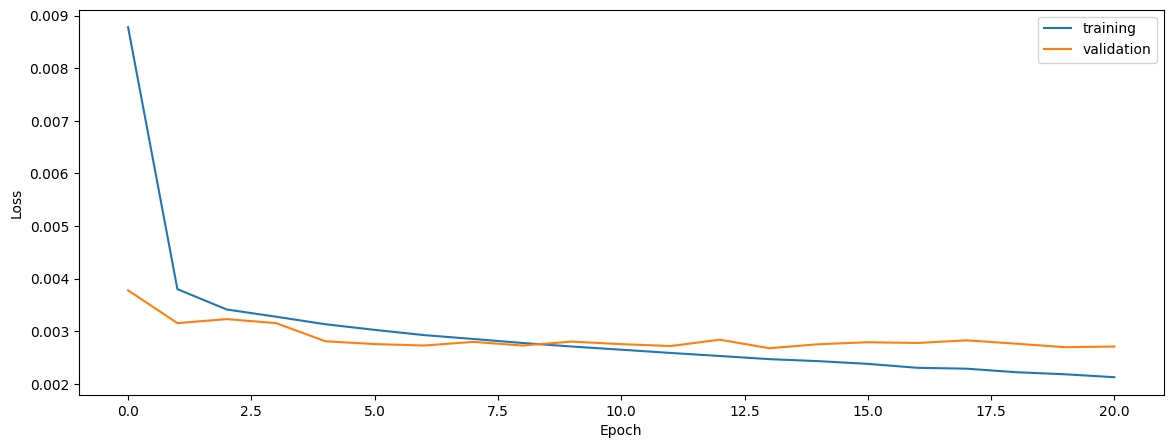

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8633891688003476
0.8307812700681372
0.8278724981952995


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.863104163946455
0.85072556695392
0.8344676125403799


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8624527447325595
0.8488809070547506
0.8300739747930187


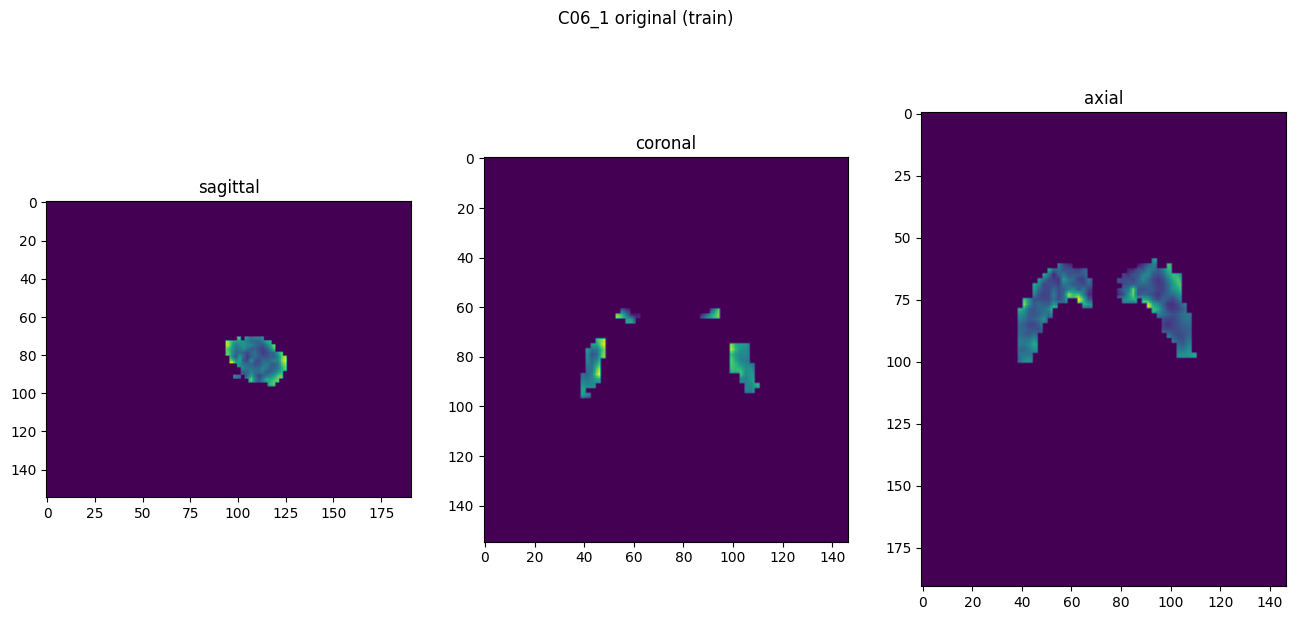

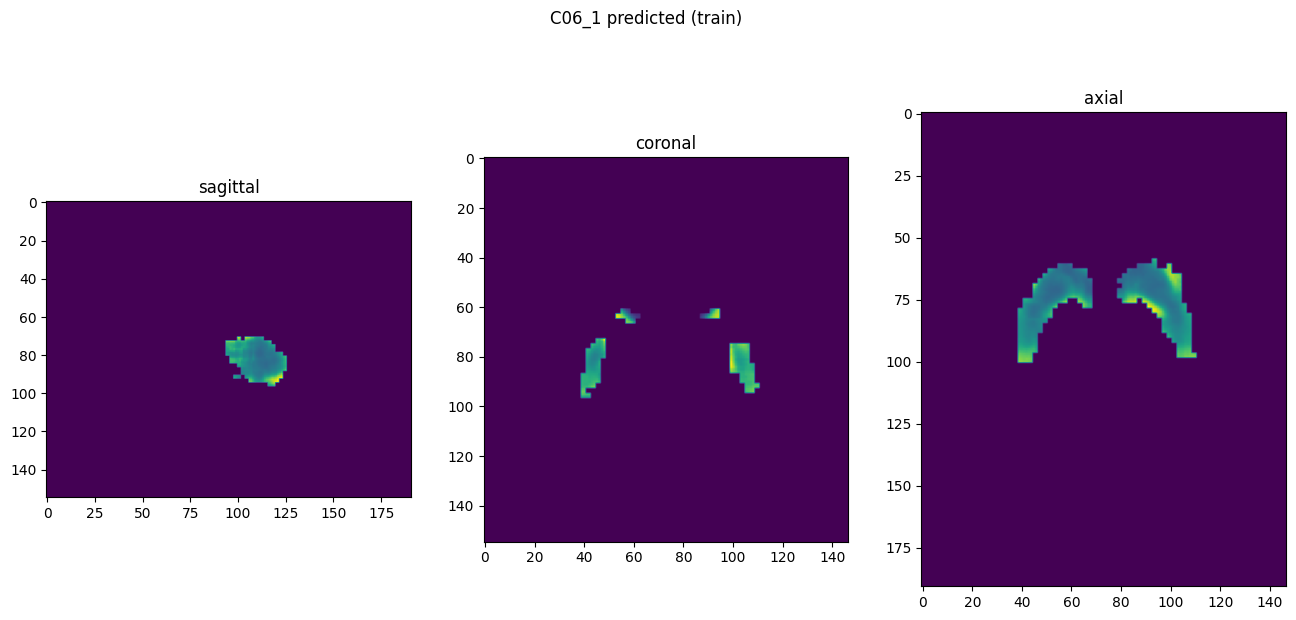

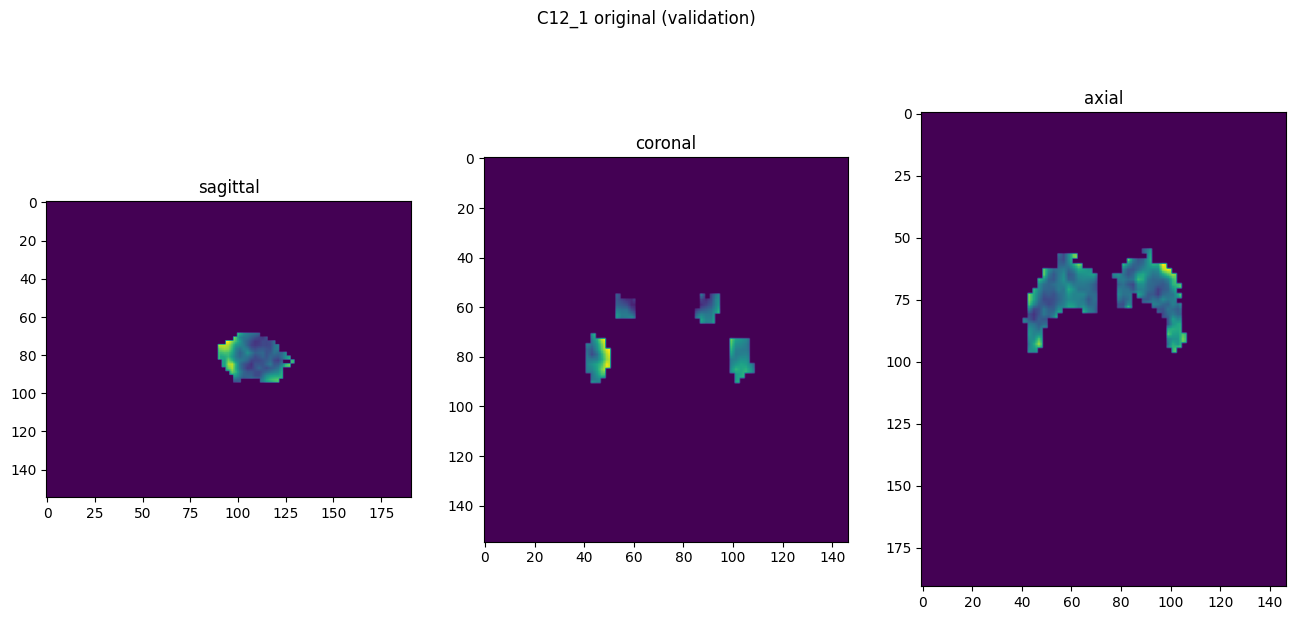

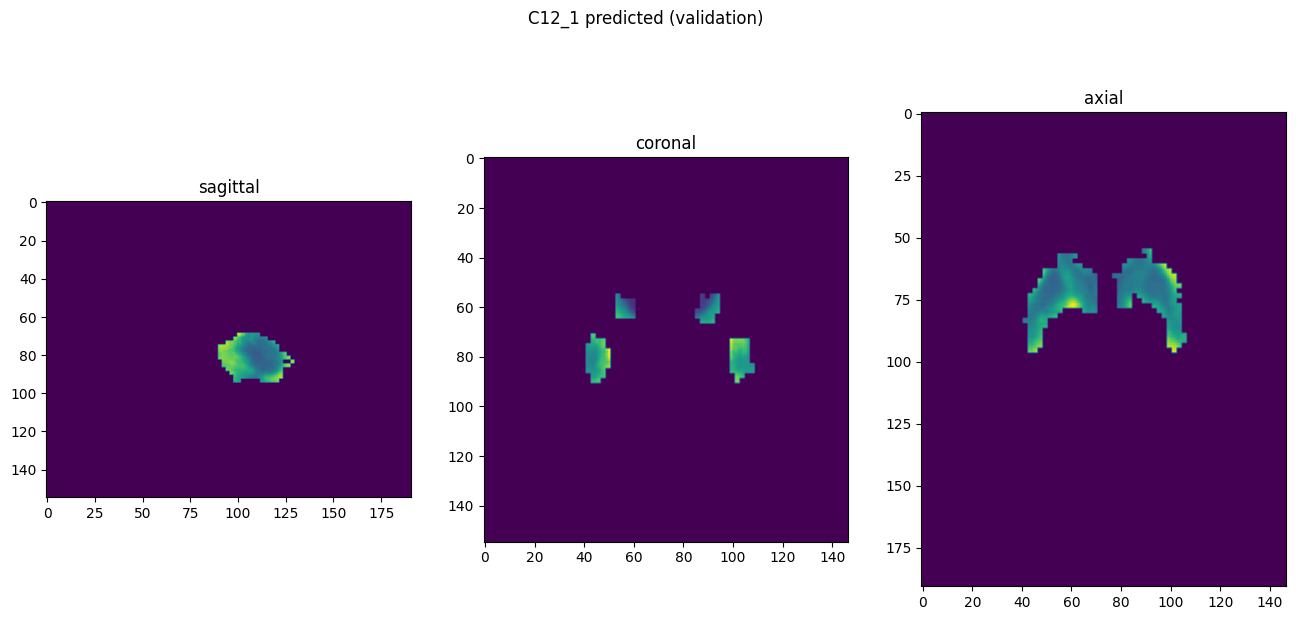

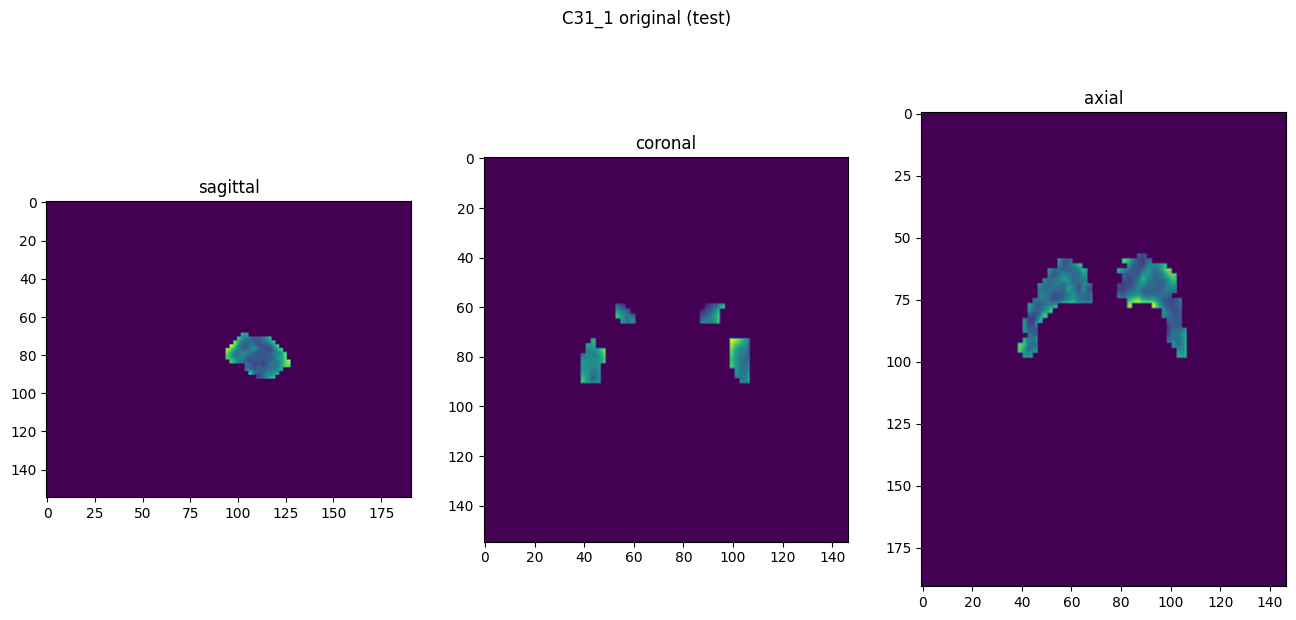

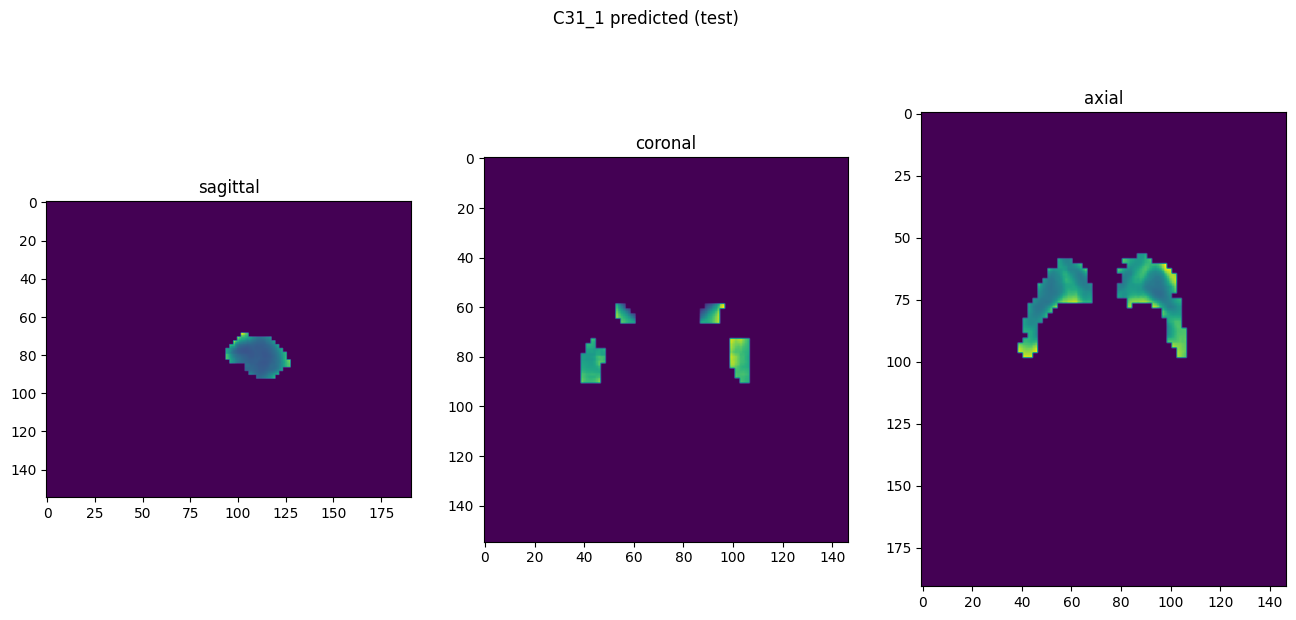

In [10]:
showResults(model, gen, threshold=None, background=False)